In [2]:
!pip install --quiet gymnasium matplotlib numpy


In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces


In [4]:
# Simple GridWorld for navigation
class GridMazeEnv(gym.Env):
    """
    0 = free, 1 = obstacle, 2 = start, 3 = goal
    Actions: 0=up, 1=right, 2=down, 3=left
    """
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, grid, max_steps=200):
        super().__init__()
        self.grid = np.array(grid)
        self.h, self.w = self.grid.shape
        self.max_steps = max_steps

        # find start & goal
        self.start_pos = tuple(np.argwhere(self.grid == 2)[0])
        self.goal_pos = tuple(np.argwhere(self.grid == 3)[0])

        # define spaces
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(self.h * self.w)

        self.reset()

    def pos_to_state(self, pos):
        r, c = pos
        return int(r * self.w + c)

    def state_to_pos(self, state):
        r, c = divmod(state, self.w)
        return (int(r), int(c))

    def reset(self, seed=None, options=None):
        self.agent_pos = self.start_pos
        self.steps = 0
        self.done = False
        return self.pos_to_state(self.agent_pos), {}

    def step(self, action):
        if self.done:
            return self.pos_to_state(self.agent_pos), 0.0, True, False, {}

        self.steps += 1
        r, c = self.agent_pos
        moves = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}
        nr, nc = r + moves[action][0], c + moves[action][1]

        # check boundaries
        if nr < 0 or nr >= self.h or nc < 0 or nc >= self.w:
            nr, nc = r, c  # invalid move

        # obstacle check
        if self.grid[nr, nc] == 1:
            reward = -0.2
            nr, nc = r, c
        else:
            reward = -0.01

        self.agent_pos = (nr, nc)

        # check goal
        done = False
        if self.agent_pos == self.goal_pos:
            reward = 1.0
            done = True
        elif self.steps >= self.max_steps:
            done = True

        self.done = done
        return self.pos_to_state(self.agent_pos), float(reward), done, False, {}

    def render(self):
        disp = np.array(self.grid, dtype=object)
        for r in range(self.h):
            for c in range(self.w):
                if disp[r,c] == 0: disp[r,c] = '.'
                elif disp[r,c] == 1: disp[r,c] = '#'
                elif disp[r,c] == 2: disp[r,c] = 'S'
                elif disp[r,c] == 3: disp[r,c] = 'G'
        ar, ac = self.agent_pos
        disp[ar, ac] = 'A'
        for row in disp:
            print(' '.join(row))
        print()


In [5]:
maze = [
    [2,0,0,0,0,0],
    [1,1,0,1,1,0],
    [0,0,0,0,1,0],
    [0,1,1,0,0,0],
    [0,0,0,1,1,0],
    [0,0,0,0,0,3]
]

env = GridMazeEnv(maze, max_steps=200)
print("Maze layout (S=start, G=goal, #=obstacle):")
env.render()


Maze layout (S=start, G=goal, #=obstacle):
A . . . . .
# # . # # .
. . . . # .
. # # . . .
. . . # # .
. . . . . G



In [6]:
n_states = env.observation_space.n
n_actions = env.action_space.n

Q = np.zeros((n_states, n_actions))

# Hyperparameters
alpha = 0.7
gamma = 0.95
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995

n_episodes = 2000
max_steps = 200

rewards_history = []
steps_history = []


In [7]:
for ep in range(n_episodes):
    state, _ = env.reset()
    total_reward = 0.0
    for t in range(max_steps):
        # epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = int(np.argmax(Q[state]))

        next_state, reward, done, _, _ = env.step(action)
        Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
        state = next_state
        total_reward += reward
        if done:
            break

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    rewards_history.append(total_reward)
    steps_history.append(t+1)

    if (ep+1) % 200 == 0:
        print(f"Episode {ep+1}/{n_episodes}, Total Reward: {total_reward:.3f}, Epsilon: {epsilon:.3f}")

print("✅ Training complete!")


Episode 200/2000, Total Reward: 0.430, Epsilon: 0.367
Episode 400/2000, Total Reward: 0.500, Epsilon: 0.135
Episode 600/2000, Total Reward: 0.910, Epsilon: 0.050
Episode 800/2000, Total Reward: 0.890, Epsilon: 0.050
Episode 1000/2000, Total Reward: 0.910, Epsilon: 0.050
Episode 1200/2000, Total Reward: 0.890, Epsilon: 0.050
Episode 1400/2000, Total Reward: 0.910, Epsilon: 0.050
Episode 1600/2000, Total Reward: 0.910, Epsilon: 0.050
Episode 1800/2000, Total Reward: 0.900, Epsilon: 0.050
Episode 2000/2000, Total Reward: 0.910, Epsilon: 0.050
✅ Training complete!


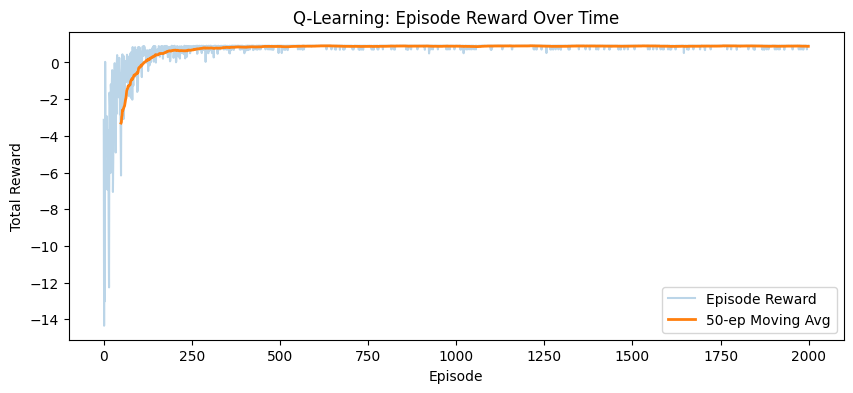

In [8]:
window = 50
smoothed = np.convolve(rewards_history, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10,4))
plt.plot(rewards_history, alpha=0.3, label='Episode Reward')
plt.plot(range(window-1, len(rewards_history)), smoothed, label=f'{window}-ep Moving Avg', linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Q-Learning: Episode Reward Over Time")
plt.legend()
plt.show()


In [9]:
state, _ = env.reset()
path = [env.state_to_pos(state)]
done = False
for _ in range(300):
    action = int(np.argmax(Q[state]))
    state, reward, done, _, _ = env.step(action)
    path.append(env.state_to_pos(state))
    if done:
        break

# Show the final path
print("Greedy path taken by the agent (A = current position):")
grid_vis = np.array(env.grid, dtype=object)
for r in range(env.h):
    for c in range(env.w):
        if grid_vis[r,c] == 0: grid_vis[r,c] = '.'
        elif grid_vis[r,c] == 1: grid_vis[r,c] = '#'
        elif grid_vis[r,c] == 2: grid_vis[r,c] = 'S'
        elif grid_vis[r,c] == 3: grid_vis[r,c] = 'G'

for i, (r,c) in enumerate(path):
    if grid_vis[r,c] not in ['S','G','#']:
        grid_vis[r,c] = str((i % 10))

for row in grid_vis:
    print(' '.join(row))
print("\nPath (coordinates):", path)
print("Reached goal:", env.agent_pos == env.goal_pos)


Greedy path taken by the agent (A = current position):
S 1 2 3 4 5
# # . # # 6
. . . . # 7
. # # . . 8
. . . # # 9
. . . . . G

Path (coordinates): [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 5), (2, 5), (3, 5), (4, 5), (5, 5)]
Reached goal: True


In [10]:
import pickle
with open('q_table.pkl', 'wb') as f:
    pickle.dump(Q, f)

print("✅ Saved Q-table to q_table.pkl — you can upload it to your repo.")


✅ Saved Q-table to q_table.pkl — you can upload it to your repo.
